<a id="top"></a>
#### QCT. Practices with Adiabatic Quantum Computing

# Perminder---Code Assignment. Nurse Scheduling Problem

Date 25th May 2022

#### Lecturers:
- Alejandro Borrallo Rentero, a.a.borrallo.rentero@accenture.com
- Rafael Martín-Cuevas Redondo, rafamartinc@pm.me
- Alberto García García, a.b.garcia.garcia@accenture.com

***

In this notebook, you will implement one instance of the Nurse Scheduling Problem, introduced by Ikeda, K., Nakamura, Y. & Humble, T.S at "Application of Quantum Annealing to Nurse Scheduling Problem". Sci Rep 9, 12837 (2019). https://doi.org/10.1038/s41598-019-49172-3


Asignment Tasks:

- To implement the three constraints of this problem (whose mathematical formulation is provided and explained on each section). (6 points)

- Adjust the Lagrange multipliers to fit the smallest dataset being considered (```nurse_scheduling_small.yml```) by using the following parameters with the CPU simulator:     number_iterations=200,temperature_start=1000 and temperature_end=10. (1 points)

- Adjust the Lagrange multipliers to fit the largest dataset being considered (```nurse_scheduling_large.yml```) by using the Digital Annealer Solver. (1 points)

- Study and analyze the effect of the following parameters: number_iterations, offset_increate_rate, temperature_start and temperature end in the energy by using the Digital Annealer for the largest dataset. (2 points)


### Table of Contents

1. [Account configuration](#account_configuration)
2. [Two-Shift System with Shift and Nurse Constraints](#nurse_scheduling_1)

    - [Pre-processing](#ns1_preprocessing)
    - [Preparing the model](#ns1_model_preparation)
    - [Add the soft nurse constraint](#ns1_soft_nurse_constraint)
    - [Add the hard shift constraint](#ns1_hard_shift_constraint)
    - [Add the hard nurse constraint](#ns1_hard_nurse_constraint)
    - [Post-processing](#ns1_postprocessing)
    - [Execution and results](#ns1_execution)
    
    
    
4. [Sources and additional references](#ref)

The following block will try to import everything we need to run this notebook. If any of the import statements fails, please make sure that your Python environment has every pip package mentioned in the [requirements.txt](/edit/requirements.txt) file provided with this notebook, and that all required auxiliary files are in the same folder as this notebook. It is important to have python 3.9 installed for this notebook to work properly.

The way to check or install a package differs from system to system, but usually you can check all the packages installed in your system with ```pip freeze``` and you can install all libraries needed for this exercise with ```pip install -r requirements.txt``` and the requirements.txt file mentioned above.

In [488]:
import os
import yaml
from dadk.BinPol import *

print('Modules imported successfully!')

Modules imported successfully!


[Back to the top](#top)

***
<a id="account_configuration"></a>

## 1. Account configuration

### Administrate credentials: ``SetAnnealerProfile``
It is best practice not to write service credentials directly into the Python code or a Jupyter notebook. The ``dadk`` uses profiles to access annealer services. Those contain all access specific content like addresses and credentials, proxies etc. 

#### Profile storage and detection
The profiles are detected and automatically loaded and used by the ``dadk``. Profiles are JSON files of a certain structure named ``annealer.prf``. Profiles are searched and stored at different locations. First it is searched in the current working directory, normally the directory  containing your Jupyter notebook. This is the local profile and if it exists it has priority versus a central profile. You can have many local profiles in different directories e.g. with credentials for different projects.

If no local profile exists it is searched for a file ``annealer.prf`` in the subdirectory ``.dadk`` within the current user's home directory. This is called the central profile and there is only one per user. It can be used as a default access point for many different projects. Beside this there is a subdirectory ``profiles`` parallel to the central ``annealer.prf``. This directory always contains a profile ``localhost.prf``, which is automatically created and points to the local machine with CPU emulation and without credentials. The ``profile`` directory can contain many profiles with different names. This is a store of passive profiles. To use them, they are copied under the name ``annealer.prf`` to the central or local location. 

### Managing  profiles 

The editing, movement and deletion of profiles need not to be done manually but is supported by the function ``SetAnnealerProfile``. When you call the function in your Jupyter notebook, it executes the action ``get effective`` which follows the search strategy local prior to central. The discovered location is displayed and the content of the profile is loaded into the GUI fields. Selecting an action and pressing the call button, credential data can be retrieved (get) or stored (put) to the local, central or store position. To determine the source in the store, select some item from ``stored profiles``. The target name for storing a profile into the store has to be entered as ``Name in profile store`` before applying the action ``put store``. For Housekeeping it is supported to delete the local and centrally stored profile.

There are different access methods to Digital annealer services. The method can be selected as ``connection_method``. This opens panes with fields to enter the corresponding address and credential information. The specific meaning of the fields is described by the labels and a help text is displayed when the mouse is over the label.

Once you have entered your profile data, you can run a solve QUBO action in the ``Optimizer`` framework to test the connection.

**Security recommendation: You should not save the fields of the ``SetAnnealerProfile`` via Notebook Widget State because they typically contain sensitive access information. It is best practice to delete the complete cell after entering and testing the profile information. It is persistent in the ``annealer.prf`` file and not needed in the Jupyter notebook any more. Also make sure not to check in a local annealer profile into a source management system like git.**

In [258]:
from dadk.JupyterTools import SetAnnealerProfile
SetAnnealerProfile()

WidgetGui(children=(VBox(children=(HBox(children=(Button(description='Call', layout=Layout(width='99%'), style…

### Manage jobs: ``CleanupJobs``
Normally the ``dadk`` manages the complete job life cycle in your account. QUBO data is transfered, a job is started, it is waited for completion, the result is retrieved and the job resources on service side are cleaned up. If in asynchronous mode the client side gives up before the job is completed (e.g. by kernel restart or shut down of the pc), then it might happen that orphaned jobs complete but are never retrieved and cleaned up. Since the number of simultaneous jobs for an account is limited, this might block new jobs from being started. Call ``CleanupJobs()`` from your Jupyter notebook and select the desired annealer profile from the drop down menu `service`. Using the function ``CleanupJobs`` you can list your current jobs, get information about or delete single jobs by entering their job id; It is possible to remove most likely orphaned jobs as obsolete jobs, which are completed for more than one hour. If you are sure about the usage of your account you can also remove all jobs. Handle this function with care, in order not to remove valuable results before they could be retrieved by the respective client.

In [ ]:
from dadk.JupyterTools import CleanupJobs
CleanupJobs()

[Back to the top](#top)

# ***
<a id="nurse_scheduling_1"></a>

## 2. Two-Shift System with Shift and Nurse Constraints

In this section, we will implement a simple version of the Nurse Scheduling Problem, described in the referenced article and defined as follows (albeit a few minor modifications, applied to simplify the formulation of the problem):

Let us consider $N$ nurses (mapped to the variable ```ǹum_nurses```), each one identified through a index $n$ (```nurse```). We want to assign the nurses to several working days from a total number of $D$ (```num_days```) to be covered, each one identified through a index $d$ (```day```). Our binary variables for this problem can be defined as $x_{n,d}$, referencing whether nurse $n$ will work on day $d$ or not. We will consider the following requirements to define our Hamiltonian:

- Each nurse will be assigned a number of working days $F_n$ (```ẁorking_days[nurse]```) that may vary from nurse to nurse, out of the total number of days available $D$. Presumably, $F_n \leq D$, leaving a number of days off as a consequence. This is described in the paper as the **soft nurse constraint**. We have removed the considerations about nurse preferences from the original paper.


- Each day, identified by the index $d$ (```day```) will have an associated workload $W_d$ (```workload[day]```) that may vary from day to day and will have to be assumed by one or several nurses. Each nurse will have an associated level of effort $E_n$ (```effort_level[nurse]```) that varies from nurse to nurse, so that the sum of the effort levels of the nurses assigned to any given date is at least equal to that day's workload. This is described in the paper as the **hard shift constraint**.


- Additionally, we want to define relations between different days and/or nurses. To do that, we will use a coefficient $J_{n,d,n',d'}$ (```penalty[nurse_1][nurse_2][day_1][day_2]```), that can act as a bonus or penalty between nurse $n$ working on day $d$ and nurse $n'$ working on day $d'$. To illustrate this possibility, we will try to avoid having the same nurse working two days in a row, by assigning a high penalty if this term is considering the same nurse ($n = n'$) over consecutive days ($d' = d + 1$). This is described in the paper as the **hard nurse constraint**.

In this scenario, there is not a clear objective function: we will have to set up the strength of each constraint correctly so that the solutions retrieved from the solver prioritize the constraints as desired. Presumably, the Lagrange multiplers of the hard constraints will be heavier than the ones associated to the soft constraint. We will now build our model considering each constraint independently.

[Back to the top](#top)

<a id="ns1_preprocessing"></a>
### 2.1. Pre-processing

We start our implementation by gathering all the data available to us: the number of nurses and days, and the parameters of our problem, detailed previously.

In [ ]:
def get_problem_data(path):
    """
    Retrieves the definition of the problem and returns all associated data.
    
    :param path: String containing the full path to the file that should be loaded.
    :return: Tuple containing the following three elements:
        - working_days: List containing the number of working days agreed with each
            nurse, for every nurse (len(working_days) == num_nurses). E.g: [1, 1, 2, 2].
        - effort_level: List containing the effort level that each nurse can deliver,
            to try to reach the total workload required for each day. E.g: [1, 4, 2, 3].
        - workload: List containing the workload associated to each day, for every
            available day (len(workload) == num_days). E.g.: [5, 5, 5].
    """
    working_days = None  # Number of working days agreed with each nurse.
    effort_level = None  # Workload that each nurse can assume.
    workload = None      # Total workload for each day.
    
    print('Loading file: {}'.format(path))

    with open(path, 'r') as ymlfile:
        data = yaml.load(ymlfile, Loader=yaml.FullLoader)
        
        working_days = [nurse['working_days'] for nurse in data['nurses']]
        effort_level = [nurse['effort_level'] for nurse in data['nurses']]
        workload = [day['workload'] for day in data['days']]
    
    if working_days and effort_level and workload and len(working_days) == len(effort_level):
        num_nurses = len(working_days)
        num_days = len(workload)
        print('Data loaded successfully: {} nurses, {} days.'.format(num_nurses, num_days))
    else:
        raise Exception('WARNING: Data could not be loaded.')
        
    return working_days, effort_level, workload

[Back to the top](#top)

<a id="ns1_model_preparation"></a>
### 2.2. Preparing the model

To fully specify our model, first we need to initialize the appropriate class. In the following sections, we will fully implement the methods described down below, that add each one of the parts that take place in the final model.

In [ ]:
def build_model(working_days, effort_level, workload,
                soft_nurse_lagrange_multiplier=1.0,
                hard_shift_lagrange_multiplier=1.0,
                consecutive_days_penalty=1.0):
    """
    Initialize and set up the binary quadratic model.
    
    :param working_days: List containing the number of working days agreed with each
        nurse, for every nurse (len(working_days) == num_nurses). E.g: [1, 1, 2, 2].
    :param effort_level: List containing the effort level that each nurse can deliver,
        to try to reach the total workload required for each day. E.g: [1, 4, 2, 3].
    :param workload: List containing the workload associated to each day, for every
        available day (len(workload) == num_days). E.g.: [5, 5, 5].
        
    :return: QUBO Model, ready to be provided to a solver.
    """
    
    print('\nBuilding Binary Quadratic Model...')
    
    # Get main parameters:
    num_nurses = len(working_days)
    num_days = len(workload)
    assert num_nurses == len(effort_level)
    
    # Create the set of variables
    my_bit_shape_array = BitArrayShape(name='tsp_array', shape=(num_nurses,num_days), axis_names=['nurse','day']) 
    my_varshapeset = VarShapeSet(my_bit_shape_array)
    
    # Constraint 1: try to adjust the number of working days for each nurse to the
    # desired value agreed with that nurse.
    constraint_1=add_soft_nurse_constraint(my_varshapeset,working_days, num_days,
                              soft_nurse_lagrange_multiplier=soft_nurse_lagrange_multiplier)

    # Constraint 2: ensure that the workload for each day is handled by one or several
    # nurses whose effort levels add up to that workload.
    constraint_2=add_hard_shift_constraint(my_varshapeset, effort_level, workload,
                              hard_shift_lagrange_multiplier=hard_shift_lagrange_multiplier)
    
    # Constraint 3: ensure that no nurse is assigned to work two days in a row.
    constraint_3=add_hard_nurse_constraint(my_varshapeset, num_nurses, num_days,
                              consecutive_days_penalty=consecutive_days_penalty)
    #return constraint_1
    return constraint_1+constraint_2+constraint_3

[Back to the top](#top)

<a id="ns1_soft_nurse_constraint"></a>
### 2.3. Adding the soft nurse constraint

Our solutions should try to comply with the number of workdays previously agreed with each nurse. As expressed below, for each nurse, if we add up all the binary variables associated to that nurse (as they either have a value of 1 if the nurse has been assigned to a specific day, and 0 otherwise), the final value should be equal to that nurse's desired total number of workdays:

$$\forall n \in \{0, 1, ..., N-1\} \rightarrow \sum \limits _{d = 0}^{D - 1}  x_{n,d} = F_n$$

We can transform this equality to a minimization by making sure that the configurations that complied with the previous equality are later associated to each of the global minima. This can be done by moving the $F_n$ to the left part of the equality and, knowing that the value of that expression is 0 when a solution is reached, we can square everything so that every other configuration (incorrect solutions) have an associated value greater than any of the correct solutions.

$$\forall n \in \{0, 1, ..., N-1\} \rightarrow argmin_x (\sum \limits _{d = 0}^{D - 1} x_{n,d} - F_n)²$$

Then, we extend this definition to consider all nurses, while still looking for the configuration that yields the minimum value:

$$argmin_x \sum \limits _{n = 0}^{N - 1} (\sum \limits _{d = 0}^{D - 1} x_{n,d} - F_n)²$$


In [659]:
def add_soft_nurse_constraint(variables_set, working_days, num_days, soft_nurse_lagrange_multiplier=1.0):
    """
    This function adds the first constraint to the Binary Quadratic Model, modifying
    it in place.
    
    :param variables_set: Set of variables for our particular problem
    :param working_days: List containing the number of working days agreed with each
        nurse, for every nurse (len(working_days) == num_nurses). E.g: [1, 1, 2, 2].
    :param num_days: Total number of days for the nurse scheduling problem.
    :param lagrange_multiplier: Lagrange multiplier for this constraint.
    
    :return: QUBO Model, ready to be provided to a solver
    """
    
    # --------------------------------------------------
    con_1=BinPol(variables_set)
    
    # ADD YOUR CODE HERE
    # \/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
    # run outer loop for nurse 
    for n in range(len(working_days)):
        con_0=BinPol(variables_set)
        con_0.add_term(-working_days[n])
        #run inner loop for days
        for d in range(num_days):
            con_0.add_term(1, (("tsp_array",n,d),))
        con_1=con_1+(con_0**2) 
    
    # /\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    # --------------------------------------------------
    
    #print(constraint_1) 
    print('   Soft nurse constraint added.')
    return soft_nurse_lagrange_multiplier*con_1

[Back to the top](#top)

<a id="ns1_hard_shift_constraint"></a>
### 2.4. Adding the hard shift constraint

The second constraint tries to ensure that the workload expected for each day will be handled by one or more nurses whose combined effort levels add up to that day's requirement. For each day, the sum of the effort levels of the nurses assigned to it should be equal to that day's workload:

$$\forall d \in \{0, 1, ..., D-1\} \rightarrow \sum \limits _{n = 0}^{N - 1}  E_n x_{n,d} = W_d$$

We can transform this equality to a minimization expression just as we did in the previous section. But this time, we will go through the entire process of reaching a version of the constraint that explicitly defines the value of each coefficient, so that we can implement it at a lower level:

$$\forall d \in \{0, 1, ..., D-1\} \rightarrow argmin_x (\sum \limits _{n = 0}^{N - 1} E_n x_{n,d} - W_d)²$$

We extend this definition to consider all days, and operate to get the final expression, while still looking for the configuration that yields the minimum value:

$$argmin_x \sum \limits _{d = 0}^{D - 1} (\sum \limits _{n = 0}^{N - 1} E_n x_{n,d} - W_d)²$$
$$argmin_x \sum \limits _{d = 0}^{D - 1} ((\sum \limits _{n = 0}^{N - 1} E_n x_{n,d})² - 2 W_d \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + W_d²)$$
$$argmin_x \sum \limits _{d = 0}^{D - 1} ((\sum \limits _{m = 0}^{N - 1} E_m x_{m,d}) \times (\sum \limits _{n = 0}^{N - 1} E_n x_{n,d}) - 2 W_d \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + W_d²)$$
$$argmin_x \sum \limits _{d = 0}^{D - 1} ((E_n x_{n,d} + \sum \limits _{m = 0, m \neq n}^{N - 1} E_m x_{m,d}) \times (\sum \limits _{n = 0}^{N - 1} E_n x_{n,d}) - 2 W_d \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + W_d²)$$
$$argmin_x \sum \limits _{d = 0}^{D - 1} (\sum \limits _{n = 0}^{N - 1} (E_n x_{n,d})² + \sum \limits _{n = 0}^{N - 1} \sum \limits _{m = 0, m \neq n}^{N - 1} E_m E_n x_{m,d} x_{n,d} - 2 W_d \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + W_d²)$$

As every $x_{n,d}$ is a binary variable with a value of either 0 or 1, $x_{n,d}² = x_{n,d}$, and therefore the first term is actually a linear term that can be added together with the other linear term of the expression. We will also remove the constant value $W_d²$ as it does not affect the location of the global minimum. This will get us to the final expression that will be implemented:

$$argmin_x \sum \limits _{d = 0}^{D - 1} (\sum \limits _{n = 0}^{N - 1} E_n² x_{n,d} + \sum \limits _{n = 0}^{N - 1} \sum \limits _{m = 0, m \neq n}^{N - 1} E_m E_n x_{m,d} x_{n,d} - 2 W_d \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + W_d²)$$
$$argmin_x \sum \limits _{d = 0}^{D - 1} ((1 - 2 W_d) \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + \sum \limits _{n = 0}^{N - 1} \sum \limits _{m = 0, m \neq n}^{N - 1} E_m E_n x_{m,d} x_{n,d} + W_d²)$$
$$argmin_x \sum \limits _{d = 0}^{D - 1} ((1 - 2 W_d) \sum \limits _{n = 0}^{N - 1} E_n x_{n,d} + \sum \limits _{n = 0}^{N - 1} \sum \limits _{m = 0, m \neq n}^{N - 1} E_m E_n x_{m,d} x_{n,d})$$


In [668]:
def add_hard_shift_constraint(variables_set, effort_level, workload, hard_shift_lagrange_multiplier=1.0):
    """
    This function adds the second constraint to the Binary Quadratic Model, modifying
    it in place.
    
    :param variables_set: Set of variables for our particular problem
    :param effort_level: List containing the effort level that each nurse can deliver,
        to try to reach the total workload required for each day. E.g: [1, 4, 2, 3].
    :param workload: List containing the workload associated to each day, for every
        available day (len(workload) == num_days). E.g.: [5, 5, 5].
    :param lagrange_multiplier: Lagrange multiplier for this constraint.
    
        
    :return: QUBO Model, ready to be provided to a solver
    """
    
    # Get main parameters:
    num_nurses = len(effort_level)
    num_days = len(workload)
    
    cons_2=BinPol(variables_set)
    # --------------------------------------------------
    # ADD YOUR CODE HERE
    # \/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
    #outer loop for days
    for d in range (num_days):
        cons_2term_1 = BinPol(variables_set)
        
        factor_A = 1-2*workload[d]
        #innerloop for nurses first term
        for n in range(num_nurses):
            cons_2term_1.add_term(factor_A*effort_level[n],(("tsp_array",n,d),))
            
        cons_2term_2 = BinPol(variables_set)
        
        #innerloop for nurses second term
        for n in range(num_nurses):
            for m in range(num_nurses):
                if(n!=m):
                    cons_2term_2.add_term(1*effort_level[n]*effort_level[m],(("tsp_array",n,d), ("tsp_array",m,d)))
        
        cons_2.add(cons_2term_1)
        cons_2.add(cons_2term_2)
       
        
    # /\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    # --------------------------------------------------
        
    print('   Hard shift constraint added.')
    return hard_shift_lagrange_multiplier*cons_2

[Back to the top](#top)

<a id="ns1_hard_nurse_constraint"></a>
### 2.5. Adding the hard nurse constraint

We will also want to avoid solutions where the same nurse works in two consecutive days. For this we will use a coefficient $J_{n,d,n',d'}$ (```penalty[nurse_1][nurse_2][day_1][day_2]```), that will act as a penalty when considering the same nurse ($n = n'$) over consecutive days ($d' = d + 1$).

Just as before, a new BQM is provided to insert the appropriate coefficients (in this case, just a bias equal to ```consecutive_days_penalty``` when two consecutive days are being considered for the same nurse), so that the new BQM can be added to the problem Hamiltonian right at the end of the method.

In [669]:
def add_hard_nurse_constraint(variables_set, num_nurses, num_days, consecutive_days_penalty=1.0):
    """
    This function adds the third constraint to the Binary Quadratic Model, modifying
    it in place, applying a penalty when the same nurse is assigned to two days in a
    row.
    
    :param variables_set: Set of variables for our particular problem
    :param num_nurses: Total number of nurses for the nurse scheduling problem.
    :param num_days: Total number of days for the nurse scheduling problem.
    
        
    :return: QUBO Model, ready to be provided to a solver
    """

    cons_3=BinPol(variables_set)    
    # Apply constraint.
    # --------------------------------------------------
    # ADD YOUR CODE HERE
    # \/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
    #outer loop for nurse
    for n in range (num_nurses):
        cons_3term_1 = BinPol(variables_set)       
        # inner loop for days. 0 to d-1
        for d in range(num_days-1):
            cons_3term_1.add_term(1*consecutive_days_penalty, (("tsp_array",n,d), ("tsp_array",n,d+1))    )
                        
        cons_3.add(cons_3term_1)

    
    # /\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    # --------------------------------------------------
            
        
    print('   Hard nurse constraint added.')
    return cons_3


[Back to the top](#top)

<a id="ns1_postprocessing"></a>
### 2.6. Post-processing

We should check our solution to ensure that it complies with all constraints and requirements from the problem.

In [670]:
def check_solution(solution, working_days, effort_level, workload):
    """
    Classically checks that nurse scheduling obtained from the solver complies with
    the given constraints.
    
    :param solution: Nurse scheduling, expressed as a list of tuples where each
        tuple references a nurse that works on a certain day. E.g.: if the solution
        were to be [(0, 0), (1, 0), (2, 1)], both nurses 0 and 1 will work on day 0,
        and nurse 2 would work on day 1.
    :param working_days: List containing the number of working days agreed with each
        nurse, for every nurse (len(working_days) == num_nurses). E.g: [1, 1, 2, 2].
    :param effort_level: List containing the effort level that each nurse can deliver,
        to try to reach the total workload required for each day. E.g: [1, 4, 2, 3].
    :param workload: List containing the workload associated to each day, for every
        available day (len(workload) == num_days). E.g.: [5, 5, 5].
    """
    
    # Get main parameters:
    num_nurses = len(working_days)
    num_days = len(workload)
    assert num_nurses == len(effort_level)
    
    check_soft_nurse_constraint(solution, num_nurses, working_days)
    check_hard_shift_constraint(solution, num_days, effort_level, workload)
    check_hard_nurse_constraint(solution, num_nurses)

In [671]:
def check_soft_nurse_constraint(solution, num_nurses, working_days):
    """
    Checks the first constraint of the nurse scheduling problem: each nurse should
    be assigned the desired number of workdays.
    
    :param solution: Nurse scheduling, expressed as a list of tuples where each
        tuple references a nurse that works on a certain day. E.g.: if the solution
        were to be [(0, 0), (1, 0), (2, 1)], both nurses 0 and 1 will work on day 0,
        and nurse 2 would work on day 1.
    :param num_nurses: Total number of nurses for the nurse scheduling problem.
    :param working_days: List containing the number of working days agreed with each
        nurse, for every nurse (len(working_days) == num_nurses). E.g: [1, 1, 2, 2].
    """
    
    print('\nChecking soft nurse constraint:')
    for nurse in range(num_nurses):
        assigned_working_days = sum(
            1
            for (assigned_nurse, assigned_day) in solution
            if nurse == assigned_nurse
        )
        print('   {} -> Nurse {} was expected to work {} days. Days assigned: {}.'.format(
            'ok!' if working_days[nurse] == assigned_working_days else 'FAIL',
            nurse, working_days[nurse], assigned_working_days
        ))

In [672]:
def check_hard_shift_constraint(solution, num_days, effort_level, workload):
    """
    Checks the second constraint of the nurse scheduling problem: the workload
    associated to each day should be handled by one or more nurses whose combined
    efforts add up to the overall effort level required.
    
    :param solution: Nurse scheduling, expressed as a list of tuples where each
        tuple references a nurse that works on a certain day. E.g.: if the solution
        were to be [(0, 0), (1, 0), (2, 1)], both nurses 0 and 1 will work on day 0,
        and nurse 2 would work on day 1.
    :param num_days: Total number of days for the nurse scheduling problem.
    :param effort_level: List containing the effort level that each nurse can deliver,
        to try to reach the total workload required for each day. E.g: [1, 4, 2, 3].
    :param workload: List containing the workload associated to each day, for every
        available day (len(workload) == num_days). E.g.: [5, 5, 5].
    """
    
    print('\nChecking hard shift constraint:')
    for day in range(num_days):
        combined_efforts = sum(
            effort_level[assigned_nurse]
            for (assigned_nurse, assigned_day) in solution
            if day == assigned_day
        )
        print('   {} -> Day {} is expected to have a workload of {}. Efforts assigned: {}.'.format(
            'ok!' if combined_efforts >= workload[day] else 'FAIL',  # '>' also valid.
            day, workload[day], combined_efforts
        ))

In [673]:
def check_hard_nurse_constraint(solution, num_nurses):
    """
    Checks the third constraint of the nurse scheduling problem: no nurse should be
    assigned to work two days in a row.
    
    :param solution: Nurse scheduling, expressed as a list of tuples where each
        tuple references a nurse that works on a certain day. E.g.: if the solution
        were to be [(0, 0), (1, 0), (2, 1)], both nurses 0 and 1 will work on day 0,
        and nurse 2 would work on day 1.
    :param num_nurses: Total number of nurses for the nurse scheduling problem.
    """
    
    print('\nChecking hard nurse constraint:')
    for nurse in range(num_nurses):
        violations=0
        violations = sum(
            1
            for (assigned_nurse, assigned_day) in solution
            if (assigned_nurse, assigned_day + 1) in solution
            and nurse==assigned_nurse
        )
        print('   {} -> Nurse {} should not work two consecutive days. Violations found: {}.'.format(
            'ok!' if violations == 0 else 'FAIL',
            nurse, violations
        ))
        

[Back to the top](#top)

<a id="ns1_execution"></a>
### 2.7. Execution and results

We can now run the entire algorithm from end to end.

In [674]:
working_days, effort_level, workload = get_problem_data(
    # Uncomment one of the following lines.
    
     'nurse_scheduling_small.yml'
     #'nurse_scheduling_medium.yml'
     #'nurse_scheduling_large.yml'
)

Loading file: nurse_scheduling_small.yml
Data loaded successfully: 4 nurses, 3 days.


Loading file: nurse_scheduling_small.yml
Data loaded successfully: 4 nurses, 3 days.

Building Binary Quadratic Model...
   Soft nurse constraint added.
   Hard shift constraint added.
   Hard nurse constraint added.
Running...
Energy of the solution:  -51500
[(0, 1), (1, 1), (2, 0), (2, 2), (3, 0), (3, 2)]

Checking soft nurse constraint:
   ok! -> Nurse 0 was expected to work 1 days. Days assigned: 1.
   ok! -> Nurse 1 was expected to work 1 days. Days assigned: 1.
   ok! -> Nurse 2 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 3 was expected to work 2 days. Days assigned: 2.

Checking hard shift constraint:
   ok! -> Day 0 is expected to have a workload of 5. Efforts assigned: 5.
   ok! -> Day 1 is expected to have a workload of 5. Efforts assigned: 5.
   ok! -> Day 2 is expected to have a workload of 5. Efforts assigned: 5.

Checking hard nurse constraint:
   ok! -> Nurse 0 should not work two consecutive days. Violations found: 0.
   ok! -> Nurse 1 should not work

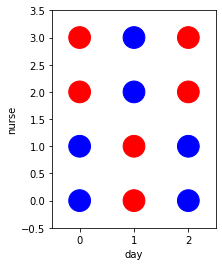

In [678]:
#################################
# ANSWER (2)  Adjust the Lagrange multipliers to fit the smallest dataset being considered (```nurse_scheduling_small.yml```) 
# by using the following parameters with the CPU simulator:     
#number_iterations=200,temperature_start=1000 and temperature_end=10. (1 points)
##############################

working_days, effort_level, workload = get_problem_data(
    # Uncomment one of the following lines.
    
    'nurse_scheduling_small.yml'
    #'nurse_scheduling_medium.yml'
    #'nurse_scheduling_large.yml'
)



qubo = build_model(
    working_days, effort_level, workload,
    soft_nurse_lagrange_multiplier=1000.0, hard_shift_lagrange_multiplier=500.0, consecutive_days_penalty=3000.0
)

# Sample.
print('Running...')
from dadk.QUBOSolverCPU import *

solver = QUBOSolverCPU(
    number_iterations=200,
    temperature_start=1000,
    temperature_end=10)

solution_list = solver.minimize(qubo)

solution = solution_list.get_minimum_energy_solution()

print('Energy of the solution: ', solution.energy)

solution = solution.extract_bit_array("tsp_array")



nurse=0
solution_processed=[]
for nurse_list in solution.data:
    day=0
    for day_worked in nurse_list:
        if(day_worked==1):
            solution_processed.append((nurse,day))
        day+=1
    nurse+=1
            
print(solution_processed)
# Check results clasically.
check_solution(solution_processed, working_days, effort_level, workload)

# Display results.
solution.draw(order=[1,0])

[Back to the top](#top)

***

<a id="ref"></a>

## 4. Sources and additional references:

- [Ikeda, K., Nakamura, Y. & Humble, T.S. Application of Quantum Annealing to Nurse Scheduling Problem. Sci Rep 9, 12837 (2019).](https://doi.org/10.1038/s41598-019-49172-3)

[Back to the top](#top)

#################################
# ( Answer 3) Adjust the Lagrange multipliers to fit the largest dataset being considered (```nurse_scheduling_large.yml```) by using the Digital Annealer Solver. (1 points)

-
###############################Large file


Loading file: nurse_scheduling_large.yml
Data loaded successfully: 37 nurses, 53 days.
Loading file: nurse_scheduling_large.yml
Data loaded successfully: 37 nurses, 53 days.

Building Binary Quadratic Model...
   Soft nurse constraint added.
   Hard shift constraint added.
   Hard nurse constraint added.
Running...
Energy of the solution:  -1291000

Checking soft nurse constraint:
   ok! -> Nurse 0 was expected to work 1 days. Days assigned: 1.
   ok! -> Nurse 1 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 2 was expected to work 4 days. Days assigned: 4.
   ok! -> Nurse 3 was expected to work 4 days. Days assigned: 4.
   ok! -> Nurse 4 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 5 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 6 was expected to work 1 days. Days assigned: 1.
   ok! -> Nurse 7 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 8 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 9 was expected 

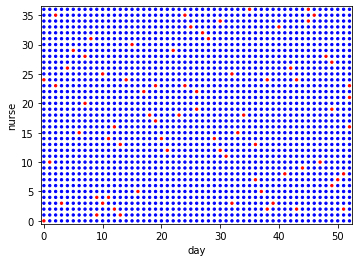

In [677]:
working_days, effort_level, workload = get_problem_data(
    # Uncomment one of the following lines.
    
     #'nurse_scheduling_small.yml'
     #'nurse_scheduling_medium.yml'
     'nurse_scheduling_large.yml'
)

working_days, effort_level, workload = get_problem_data(
    # Uncomment one of the following lines.
    
    #'nurse_scheduling_small.yml'
     #'nurse_scheduling_medium.yml'
    'nurse_scheduling_large.yml'
)

qubo = build_model(
    working_days, effort_level, workload,
    soft_nurse_lagrange_multiplier=12000.0, hard_shift_lagrange_multiplier=1000.0, consecutive_days_penalty=4000.0
)

#*works a
#qubo = build_model(
#    working_days, effort_level, workload,
#    soft_nurse_lagrange_multiplier=12000.0, hard_shift_lagrange_multiplier=1000.0, consecutive_days_penalty=4000.0
#)*#
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=2000000,temperature_start= 300000,temperature_end=1000,
#number_runs=128)


# Sample.
print('Running...')
from dadk.QUBOSolverCPU import *
from dadk.QUBOSolverDAv2 import *

#solver = QUBOSolverCPU(number_iterations=200,temperature_start=1000,temperature_end=10)



#################################################################
# ANSWER  4 - Study and analyze the effec t of the following parameters: number_iterations, offset_increate_rate, temperature_start 
# and temperature end in the energy by using the Digital Annealer for the largest dataset. (2 points)
#################################################################


# ###########
#This gave worse results for below values for number_iterations0,temperature_start,temperature_end,number_runs to higher values
##########################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=200,temperature_start=1000,temperature_end=10,
                        #number_runs=20)

#solver = QUBOSolverDAv2(number_iterations=20000, use_access_profile=True,number_runs=10000,auto_tuning=2,temperature_start=1000,
     #temperature_end=10,offset_increase_rate=100)
    
    
    
###########################
#4.1
#increase the number_iterationss- 2 million ,temperature_start,temperature_end,number_runs to higher values
#The enrgy value is 1287000
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 300000,temperature_end=1000,
                        #number_runs=128)
    

###########################
#4.2
#increase the number_iterations0 to 20 million. This give only slight better results as energy=1289000
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 300000,temperature_end=1000,
                        #number_runs=128)

    
###########################
#4.3 When the num_runs=200> 128 got error as value should be less than or = 128
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 300000,temperature_end=1000,
                        #number_runs=200)
    
    
###########################
#4.4 increase the temperature_start= 400000 just increase by 100000
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 400000,temperature_end=1000,
                        #number_runs=128)


########################### Best results
#4.5 increase the temperature_start= 3000000 (increase by 10 fold). we got better value for energy and all the constraints are ok, 
#nothing failed
##################################
solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 3000000,temperature_end=1000,
                        number_runs=128)

solution_list = solver.minimize(qubo)

solution = solution_list.get_minimum_energy_solution()

print('Energy of the solution: ', solution.energy)
#print('Energy of the solution: ', solution)
solution = solution.extract_bit_array("tsp_array")



nurse=0
solution_processed=[]
for nurse_list in solution.data:
    day=0
    for day_worked in nurse_list:
        if(day_worked==1):
            solution_processed.append((nurse,day))
        day+=1
    nurse+=1
            
#print(solution_processed)
# Check results clasically.
check_solution(solution_processed, working_days, effort_level, workload)

# Display results.
solution.draw(order=[1,0])

# 4 Analysis values for 
number_iterations0,temperature_start,temperature_end,number_runs to higher values


# 4.1 We get better results when we increase the values for number_iterations=2000000*2 million), temperature_start=300000, temperature_end=1000, and number_runs=128

The energy of the solution is Energy of the solution:  -1287000

# 4.2  when  values for number_iterations=20000000 *20 million) 

The Energy of the solution:  -1289000
only slightly better

# 4.3 When the num_runs= 200

We got ValueError: Something went wrong: {"code":3,"details":[],"error":"num_runs, 200, must be less than or equal to 128. 
         Valid range is [16, 128].\n: Parameter out of bound.","message":"num_runs, 200, 
         must be less than or equal to 128. Valid range is [16, 128].\n: Parameter out of bound.","status":"Deleted"

# 4.4 when increased temperature_start=400000, no improvement as 
Energy of the solution:  -1289000

# 4.5 when increased temperature_start=3000000, no improvement as 
Energy of the solution:  -1291000

All of the constraintes where Ok. Nothing failed.

Loading file: nurse_scheduling_large.yml
Data loaded successfully: 37 nurses, 53 days.
Loading file: nurse_scheduling_large.yml
Data loaded successfully: 37 nurses, 53 days.

Building Binary Quadratic Model...
   Soft nurse constraint added.
   Hard shift constraint added.
   Hard nurse constraint added.
Running...
Energy of the solution:  -1289000

Checking soft nurse constraint:
   ok! -> Nurse 0 was expected to work 1 days. Days assigned: 1.
   ok! -> Nurse 1 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 2 was expected to work 4 days. Days assigned: 4.
   ok! -> Nurse 3 was expected to work 4 days. Days assigned: 4.
   ok! -> Nurse 4 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 5 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 6 was expected to work 1 days. Days assigned: 1.
   ok! -> Nurse 7 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 8 was expected to work 2 days. Days assigned: 2.
   ok! -> Nurse 9 was expected 

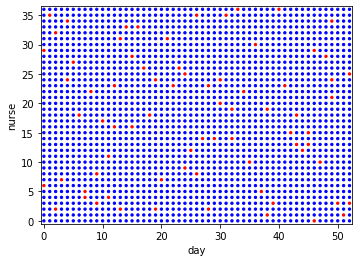

In [679]:
working_days, effort_level, workload = get_problem_data(
    # Uncomment one of the following lines.
    
     #'nurse_scheduling_small.yml'
     #'nurse_scheduling_medium.yml'
     'nurse_scheduling_large.yml'
)

working_days, effort_level, workload = get_problem_data(
    # Uncomment one of the following lines.
    
    #'nurse_scheduling_small.yml'
     #'nurse_scheduling_medium.yml'
    'nurse_scheduling_large.yml'
)

qubo = build_model(
    working_days, effort_level, workload,
    soft_nurse_lagrange_multiplier=12000.0, hard_shift_lagrange_multiplier=1000.0, consecutive_days_penalty=4000.0
)

#*works a
#qubo = build_model(
#    working_days, effort_level, workload,
#    soft_nurse_lagrange_multiplier=12000.0, hard_shift_lagrange_multiplier=1000.0, consecutive_days_penalty=4000.0
#)*#
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=2000000,temperature_start= 300000,temperature_end=1000,
#number_runs=128)


# Sample.
print('Running...')
from dadk.QUBOSolverCPU import *
from dadk.QUBOSolverDAv2 import *

#solver = QUBOSolverCPU(number_iterations=200,temperature_start=1000,temperature_end=10)



#################################################################
# ANSWER  4 - Study and analyze the effec t of the following parameters: number_iterations, offset_increate_rate, temperature_start 
# and temperature end in the energy by using the Digital Annealer for the largest dataset. (2 points)
#################################################################


# ###########
#This gave worse results for below values for number_iterations0,temperature_start,temperature_end,number_runs to higher values
##########################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=200,temperature_start=1000,temperature_end=10,
                        #number_runs=20)

#solver = QUBOSolverDAv2(number_iterations=20000, use_access_profile=True,number_runs=10000,auto_tuning=2,temperature_start=1000,
     #temperature_end=10,offset_increase_rate=100)
    
    
    
###########################
#4.1
#increase the number_iterationss- 2 million ,temperature_start,temperature_end,number_runs to higher values
#The enrgy value is 1287000
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 300000,temperature_end=1000,
                        #number_runs=128)
    

###########################
#4.2
#increase the number_iterations0 to 20 million. This give only slight better results as energy=1289000
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 300000,temperature_end=1000,
                        #number_runs=128)

    
###########################
#4.3 When the num_runs=200> 128 got error as value should be less than or = 128
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 300000,temperature_end=1000,
                        #number_runs=200)
    
    
###########################
#4.4 increase the temperature_start= 400000 just increase by 100000
##################################
#solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 400000,temperature_end=1000,
                        #number_runs=128)


########################### Best results
#4.5 increase the temperature_start= 3000000 (increase by 10 fold). we got better value for energy and all the constraints are ok, 
#nothing failed
##################################
solver = QUBOSolverDAv2( use_access_profile=True,number_iterations=20000000,temperature_start= 3000000,temperature_end=1000,
                        number_runs=128)

solution_list = solver.minimize(qubo)

solution = solution_list.get_minimum_energy_solution()

print('Energy of the solution: ', solution.energy)
#print('Energy of the solution: ', solution)
solution = solution.extract_bit_array("tsp_array")



nurse=0
solution_processed=[]
for nurse_list in solution.data:
    day=0
    for day_worked in nurse_list:
        if(day_worked==1):
            solution_processed.append((nurse,day))
        day+=1
    nurse+=1
            
#print(solution_processed)
# Check results clasically.
check_solution(solution_processed, working_days, effort_level, workload)

# Display results.
solution.draw(order=[1,0])